In [13]:
import sys
sys.path.append('../Codes/lib/')
sys.path.append('../Codes/Python/')
import numpy as np
import matplotlib.pyplot as plt
from Immuno_models import*
#from Bio import Phylo
from io import StringIO
from matplotlib.lines import Line2D
from datetime import datetime, timedelta
import scipy.special as sc
import os.path
import pickle
from matplotlib import style
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from IPython.display import display, Math
import json

Text_files_path = '../../../../Dropbox/Research/Evolution_Immune_System/Text_files/'

def my_linear_func(x, a, b):
    return a + b*x
def my_quadratic_func(x, a, b, c):
    return np.log(a)+np.log(np.sqrt(-b)) + b*(x-c)**2

N_A = 6.02214076e23
k_BT = 1.380649e-23*293
style.use('seaborn-paper')
print(style.available)
%autosave 60

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


Autosaving every 60 seconds


In [14]:
%%time
mu = 1
nu = 3
T = 15
dT = 0.1
alpha = 1e-5
time = np.linspace(0, T, int(T/dT))
wt_exp = np.exp(mu*time)
mutant_size_exp = np.array([])
mutant_size_lin = np.array([])
N = 1000
for n in range(N):
    n_mutants = np.array([])
    for t in range(len(time)):
        a = np.random.poisson(wt_exp[t]*alpha)
        for m in range(a):
            n_mutants = np.append(n_mutants, np.exp(nu*(T-time[t])))
    mutant_size_exp = np.append(mutant_size_exp, n_mutants)

CPU times: user 3.63 s, sys: 759 ms, total: 4.39 s
Wall time: 4.61 s


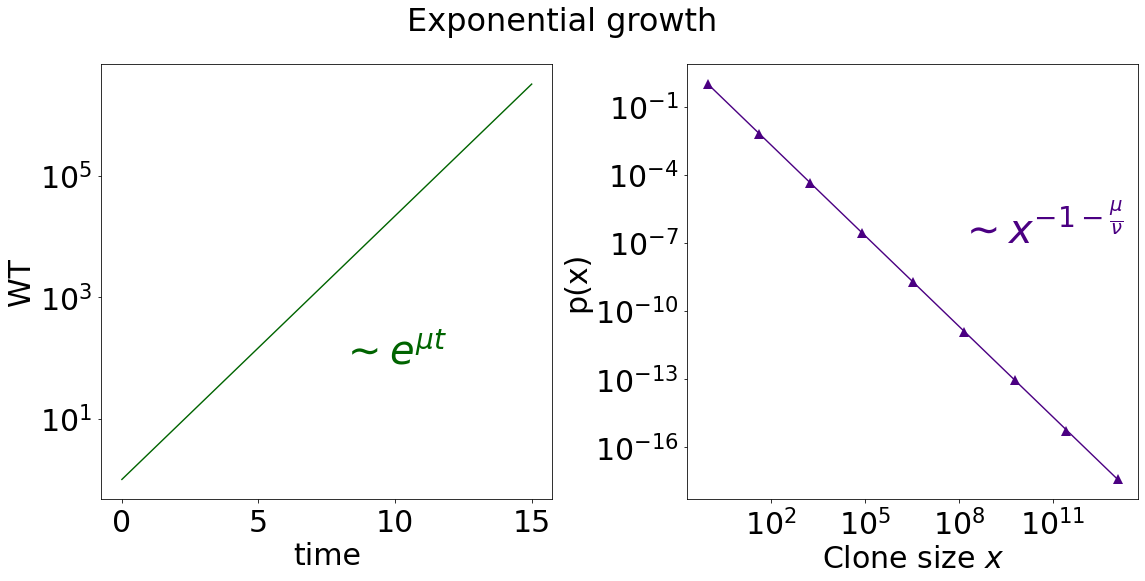

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(20,8), gridspec_kw={'left':0.18, 'wspace':0.3})
fig.suptitle('Exponential growth', fontsize = 32)
ax[0].plot(time, wt_exp, color = 'darkgreen')
ax[0].set_yscale('log')
ax[0].set_xlabel('time', fontsize = 30)
ax[0].set_ylabel('WT', fontsize = 30)
ax[0].tick_params(labelsize = 30)
ax[0].text(x = 8, y = 8e1, s = r'$\sim e^{\mu t}$', fontsize = 40, color = 'darkgreen')
data_size = np.histogram(mutant_size_exp, bins = np.logspace(np.log10(np.min(mutant_size_exp)),np.log10(np.max(mutant_size_exp)), 10), density = True)
clone_size = np.logspace(np.log10(data_size[1][0]),np.log10(data_size[1][-2]), 100)
ax[1].plot(data_size[1][:-1], data_size[0]/(data_size[0])[0], marker = '^', linestyle = '', ms = 10, color = 'indigo')
ax[1].plot(clone_size, clone_size**(-1-(mu/nu))/(clone_size**(-1-(mu/nu)))[0], color = 'indigo')
ax[1].text(x = 1e8, y = 1e-7, s = r'$\sim x^{-1-\frac{\mu}{\nu}}$', fontsize = 40, color = 'indigo')
ax[1].set_xlabel('Clone size $x$', fontsize = 30)
ax[1].set_ylabel('p(x)', fontsize = 30)
ax[1].tick_params(labelsize = 30)
ax[1].set_yscale('log')
ax[1].set_xscale('log')
fig.savefig('../Figures/2_LD/exponential_growth.eps')


In [51]:
%%time
mu = 1
nu = 1
T = 20
dT = 0.1
alpha = 1e-5
lambd = 1
time = np.linspace(0, T, int(T/dT))
wt_lin = (10*mu*time)**lambd
mutant_size_lin = np.array([])
N = 20000
for n in range(N):
    n_mutants = np.array([])
    for t in range(len(time)):
        a = np.random.poisson(wt_lin[t]*alpha)
        for m in range(a):
            n_mutants = np.append(n_mutants, np.exp(nu*(T-time[t])))
    mutant_size_lin = np.append(mutant_size_lin, n_mutants)
print(np.log10(np.max(mutant_size_lin)))

8.598594264818152
CPU times: user 6.29 s, sys: 73.8 ms, total: 6.36 s
Wall time: 6.3 s


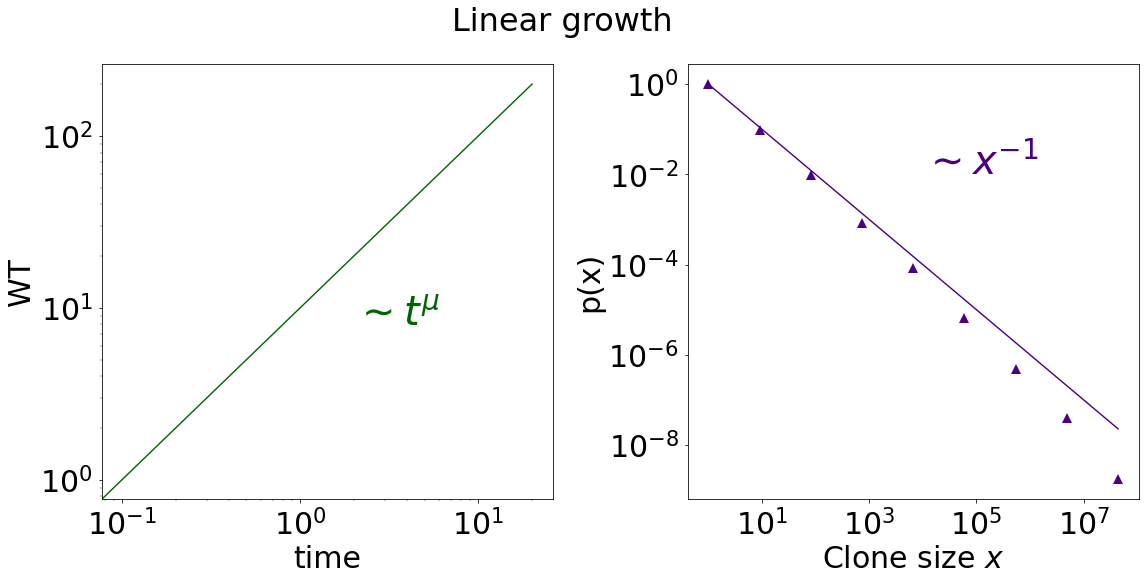

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(20,8), gridspec_kw={'left':0.18, 'wspace':0.3})
fig.suptitle('Linear growth', fontsize = 32)
ax[0].plot(time, wt_lin, color = 'darkgreen')
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('time', fontsize = 30)
ax[0].set_ylabel('WT', fontsize = 30)
ax[0].tick_params(labelsize = 30)
ax[0].text(x = 2e0, y = 8e0, s = r'$\sim t^{\mu}$', fontsize = 40, color = 'darkgreen')

#log_exp = (((10*mu)*((lambd*10*mu)/(nu))**(1/(lambd-1)))/(nu))
#print(log_exp)
data_size = np.histogram(mutant_size_lin, bins = np.logspace(np.log10(np.min(mutant_size_lin)),np.log10(np.max(mutant_size_lin)), 10), density = True)
clone_size = np.logspace(np.log10(data_size[1][0]),np.log10(data_size[1][-2]), 10)
ax[1].plot(data_size[1][:-1], data_size[0]/(data_size[0])[0], linestyle = '', marker = '^', ms = 10, color = 'indigo')
#ax[1].plot(clone_size, ((log_exp*np.log(clone_size)))**(lambd-1)*clone_size**(-1)/((log_exp*np.log(clone_size))**(lambd-1)*clone_size**(-1))[1])
ax[1].plot(clone_size, clone_size**(-1)/(clone_size**(-1))[0], color = 'indigo')
ax[1].text(x = 1e4, y = 1e-2, s = r'$\sim x^{-1}$', fontsize = 40, color = 'indigo')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlabel('Clone size $x$', fontsize = 30)
ax[1].set_ylabel('p(x)', fontsize = 30)
ax[1].tick_params(labelsize = 30)
fig.savefig('../Figures/2_LD/linear_growth.eps')


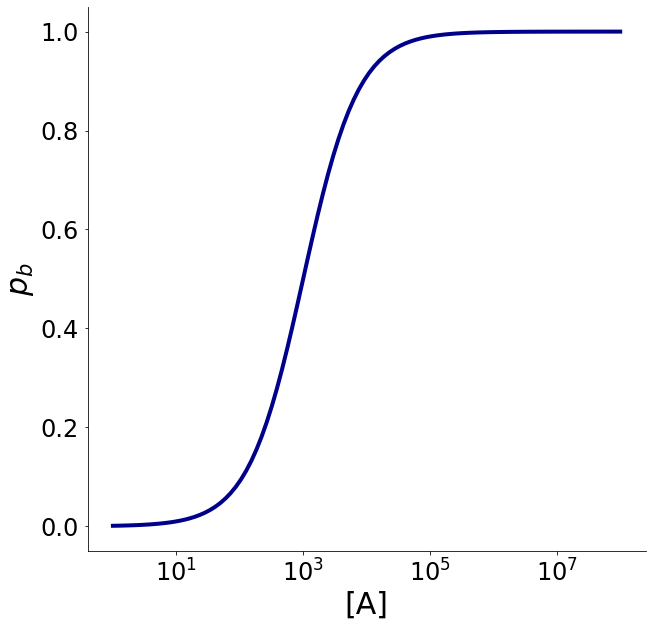

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
x = np.logspace(0, 8, 100)
y = x/(x+1e3)
ax.plot(x, y, lw = 4, color = 'darkblue')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
my_plot_layout(ax = ax, xscale = 'log', xlabel = '[A]', ylabel = r'$p_b$', x_fontsize = 30, y_fontsize = 30)
fig.savefig('../Figures/binding_probability.png')

In [27]:
a  = np.array(['a', 'b'], dtype = String_ )

NameError: name 'string_' is not defined

In [26]:
np.add(['a'],  ['b'])

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U1'), dtype('<U1')) -> dtype('<U1')